## Importing Libraries,Dataset

In [1]:
import nltk
nltk.download('stopwords')
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from scipy import spatial
from sklearn.manifold import TSNE

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\seshi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
train_bodies=pd.read_csv('train_bodies.csv')
train_stances=pd.read_csv('train_stances.csv')

In [3]:
train_data=pd.merge(train_bodies,train_stances,how='left',on='Body ID')

In [4]:
test_stance = pd.read_csv('competition_test_stances.csv')
test_body = pd.read_csv('test_bodies.csv')

In [5]:
test_data  = pd.merge( test_body, test_stance,how='left', on='Body ID')

In [6]:
target={'unrelated':0, 'agree':1, 'discuss':2, 'disagree':3}
train_data['Stance']=train_data['Stance'].map(target)

In [7]:
train_data

,Body ID,articleBody,Headline,Stance
0,0,A small meteorite crashed into a wooded area i...,"Soldier shot, Parliament locked down after gun...",0
1,0,A small meteorite crashed into a wooded area i...,Tourist dubbed ‘Spider Man’ after spider burro...,0
2,0,A small meteorite crashed into a wooded area i...,Luke Somers 'killed in failed rescue attempt i...,0
3,0,A small meteorite crashed into a wooded area i...,BREAKING: Soldier shot at War Memorial in Ottawa,0
4,0,A small meteorite crashed into a wooded area i...,Giant 8ft 9in catfish weighing 19 stone caught...,0
...,...,...,...,...
49967,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets tipped more than $2,00...",1
49968,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Pizza delivery man gets $2,000 tip",1
49969,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...","Luckiest Pizza Delivery Guy Ever Gets $2,000 Tip",1
49970,2532,"ANN ARBOR, Mich. – A pizza delivery man in Mic...",Ann Arbor pizza delivery driver surprised with...,1


## Data Preprocessing

In [8]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
import string
stop_words=set(stopwords.words('english'))
stemmer = PorterStemmer()
def preprocessing(text):
    
    text = text.rstrip(',|.|;|:|\'|\"')
    text = text.lstrip('\'|\"')
    #remove numbers
    text=re.sub(r'\d+','',text)
    #punctuation removal
    translator=str.maketrans('','',string.punctuation)
    text=text.translate(translator)
    text=" ".join(text.split())
    #stop words removal
    word_tokens=word_tokenize(text)
    filtered_text = [word for word in word_tokens if word not in stop_words]
    text=" ".join(filtered_text)
    #stemming
    word_tokens = word_tokenize(text)
    stems = [stemmer.stem(word) for word in word_tokens]
    text=" ".join(stems)
    #lowering the text
    text=text.lower()
    
    return text

In [9]:
train_data['new_headline']=train_data['Headline'].map(preprocessing)

In [10]:
train_data['new_articlebody']=train_data['articleBody'].map(preprocessing)

In [11]:
test_data['new_Headline']=test_data['Headline'].map(preprocessing)
test_data['new_articlebody']=test_data['articleBody'].map(preprocessing)

In [12]:
test_data['Stance']=test_data['Stance'].map(target)

In [13]:
#preprocessed train data
xtrain_prepdata=train_data[['new_headline','new_articlebody']]
ytrain_prepdata=train_data['Stance']
#unpreprocessed train data
xtrain_unprepdata=train_data[['Headline','articleBody']]
ytrain_unprepdata=train_data['Stance']
#preprocessed text  data
xtest_prepdata=test_data[['new_Headline','new_articlebody']]
ytest_prepdata=test_data['Stance']
#unpreprocessed text data
xtest_unprepdata=test_data[['Headline','articleBody']]
ytest_unprepdata=test_data['Stance']

## Text to Sequence and Word Embedding

In [14]:
from tensorflow.keras.preprocessing.text import Tokenizer
from nltk.tokenize import word_tokenize
X_train_prep_combined = train_data['new_headline'] + train_data['new_articlebody']
X_train_prep_combined = pd.DataFrame(X_train_prep_combined)
X_train_prep_combined.columns = ['combined']
tokens1=[]
def tokens(text):
    tokens=word_tokenize(text)
    tokens1.append(tokens)
X_train_prep_combined['combined'].apply(tokens)
tokenizer = Tokenizer(num_words=len(tokens1))
tokenizer.fit_on_texts(X_train_prep_combined['combined'])
words_to_index = tokenizer.word_index

In [15]:
len(words_to_index)

40423

In [16]:
def read_glove_vector(glove_vec):
  with open(glove_vec, 'r', encoding='UTF-8') as f:
    words = set()
    word_to_vec_map = {}
    for line in f:
      w_line = line.split()
      curr_word = w_line[0]
      word_to_vec_map[curr_word] = np.array(w_line[1:], dtype=np.float64)
  return word_to_vec_map

In [17]:
word_to_vec_map = read_glove_vector('glove.6B.100d.txt')

In [18]:
vocab_len = len(words_to_index)
embed_vector_len = word_to_vec_map['moon'].shape[0]

emb_matrix = np.zeros((vocab_len, embed_vector_len))

for word, index in words_to_index.items():
  embedding_vector = word_to_vec_map.get(word)
  if embedding_vector is not None:
    emb_matrix[index, :] = embedding_vector


In [19]:
count=[]
def max_len(text):
    count.append(len(text.split()))
X_train_prep_combined['combined'].apply(max_len)
max(count)

2900

In [20]:
from keras.utils import pad_sequences
head = tokenizer.texts_to_sequences(X_train_prep_combined['combined'])
head = pad_sequences(head, maxlen=max(count), padding='post')
head

array([[  264,    63,   318, ...,     0,     0,     0],
       [ 2420,  2610,   120, ...,     0,     0,     0],
       [ 1575,   926,    36, ...,     0,     0,     0],
       ...,
       [15336,  2028,  1776, ...,     0,     0,     0],
       [ 4164,  4682,  2028, ...,     0,     0,     0],
       [ 4164,  4682,  2028, ...,     0,     0,     0]])

In [21]:
head.shape

(49972, 2900)

## CNN-LSTM Model

In [25]:
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Embedding, Input, Lambda, LSTM, Bidirectional
from keras.optimizers import SGD, Adagrad
from keras.layers.convolutional import Conv1D
from keras.layers.pooling import MaxPooling1D, GlobalMaxPooling1D, AveragePooling1D
from keras.layers import concatenate

In [23]:
train_head = tokenizer.texts_to_sequences(train_data['new_headline'])
train_head = pad_sequences(train_head, maxlen=30, padding='post')
train_body = tokenizer.texts_to_sequences(train_data['new_articlebody'])
train_body = pad_sequences(train_body, maxlen=500, padding='post')
test_head = tokenizer.texts_to_sequences(test_data['new_Headline'])
test_head = pad_sequences(test_head, maxlen=30, padding='post')
test_body = tokenizer.texts_to_sequences(test_data['new_articlebody'])
test_body = pad_sequences(test_body, maxlen=500, padding='post')

In [60]:
result = pd.concat([pd.DataFrame(train_head), pd.DataFrame(train_body)], axis=1, join='inner')
y_train = train_data['Stance']

In [61]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 2)
result,y_train  = sm.fit_resample(result, y_train)

In [63]:
from keras.layers import Reshape
head_input = Input(shape=(30,), dtype='int32', name='head_input')
body_input = Input(shape=(500,), dtype='int32', name='body_input')
embedding_layer = Embedding(len(words_to_index),100,weights=[emb_matrix],input_length=max(count),trainable=False)
head_embed = embedding_layer(head_input)
body_embed = embedding_layer(body_input)

pool_1 = MaxPooling1D(pool_size=3, strides=2, name='pool3')
conv_1 = Conv1D(64, 5, activation='relu', name='conv1')
head_CNN = conv_1(head_embed)
head_CNN = pool_1(head_CNN)
head_CNN = Flatten()(head_CNN)
conv_2 = Conv1D(64, 5, activation='relu', name='conv2')
body_CNN = conv_2(body_embed)
body_CNN = pool_1(body_CNN)
body_CNN = Flatten()(body_CNN)
conc = concatenate([head_CNN,body_CNN])

lstm_input = Reshape((-1, conc.shape[1]))(conc)
lstm = LSTM(100)(lstm_input)

dense = Dense(100,activation='relu')(lstm)
dense = Dropout(0.3)(dense)
dense = Dense(4,activation='softmax')(dense)
model = Model(inputs=[head_input,body_input], outputs=[dense])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['acc'])
print(model.summary())

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 head_input (InputLayer)        [(None, 30)]         0           []                               
                                                                                                  
 body_input (InputLayer)        [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        multiple             4042300     ['head_input[0][0]',             
                                                                  'body_input[0][0]']             
                                                                                                  
 conv1 (Conv1D)                 (None, 26, 64)       32064       ['embedding_2[0][0]']      

In [62]:
test_x = pd.concat([pd.DataFrame(test_head), pd.DataFrame(test_body)], axis=1, join='inner')

In [64]:
model.fit([result.iloc[:,:30],result.iloc[:,30:]],y_train,validation_data = ([test_x.iloc[:,:30],test_x.iloc[:,30:]],ytest_prepdata),epochs=4, batch_size=128,verbose = True)

Epoch 1/4
1143/1143 [==============================] - 633s 541ms/step - loss: 0.6351 - acc: 0.7371 - val_loss: 2.1663 - val_acc: 0.3515
Epoch 2/4
1143/1143 [==============================] - 633s 554ms/step - loss: 0.3910 - acc: 0.8453 - val_loss: 2.7559 - val_acc: 0.3750
Epoch 3/4
1143/1143 [==============================] - 589s 516ms/step - loss: 0.2975 - acc: 0.8841 - val_loss: 3.0162 - val_acc: 0.3763
Epoch 4/4
1143/1143 [==============================] - 403s 353ms/step - loss: 0.2303 - acc: 0.9125 - val_loss: 3.0035 - val_acc: 0.4217


In [65]:
y_pred = model.predict([test_x.iloc[:,:30],test_x.iloc[:,30:]])

795/795 [==============================] - 18s 22ms/step


In [66]:
labels = np.argmax(y_pred, axis=-1)    
print(labels)

[3 2 0 ... 2 2 3]


In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest_prepdata,labels)
cm

array([[7792, 3616, 5304, 1637],
       [ 494,  645,  469,  295],
       [1051,  840, 2160,  413],
       [ 174,  197,  206,  120]], dtype=int64)

<AxesSubplot:>

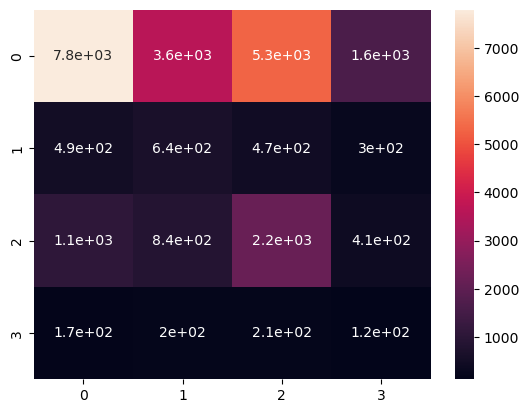

In [68]:
import seaborn as sns
sns.heatmap(cm, annot=True)